In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from tqdm import tqdm
import transformers

In [ ]:
score_df = pd.read_csv('data.csv', index_col=0)
print("Total number of samples: ", score_df.shape[0])
score_df.head()

Total number of samples:  5919


,question,refanswer,answer,score_avg
id,,,,
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0


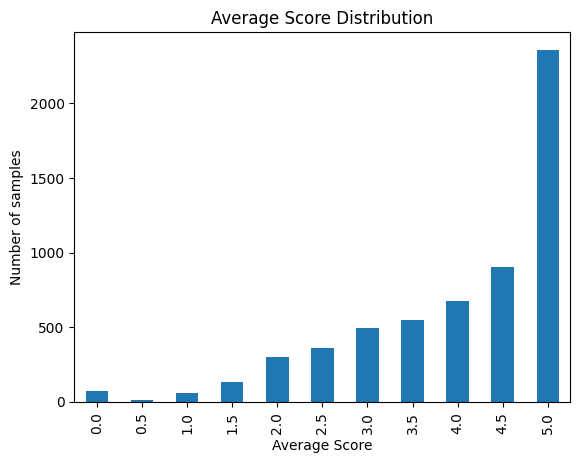

In [ ]:
score_df['score_avg'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Average Score')
plt.ylabel('Number of samples')
plt.title('Average Score Distribution')
plt.show()

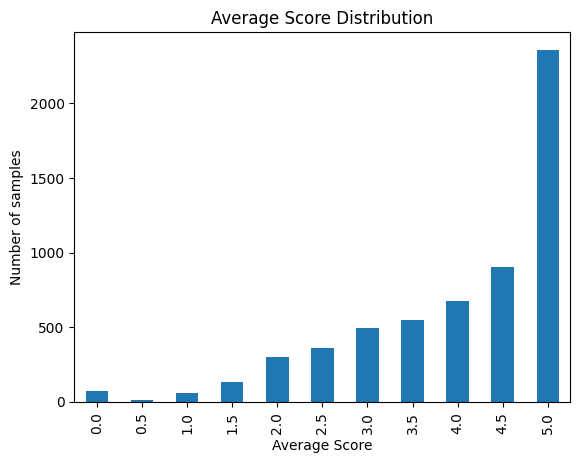

In [ ]:
# Rounding to nearest .5 value
score_df['score_avg'] = score_df['score_avg'].apply(lambda x: round(x * 2) / 2)
score_df['score_avg'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Average Score')
plt.ylabel('Number of samples')
plt.title('Average Score Distribution')
plt.show()


In [ ]:
# Define the function to generate BERT embeddings

model_name = 'bert-base-uncased'
def generate_bert_embeddings(text):
    """
    Generates BERT embeddings for a list of texts.

    Args:
        model_name: The name of the BERT model to use.
        texts: A list of strings.

    Returns:
        A DataFrame containing BERT embeddings for each text.
    """
    # text = [text]

    # Load the BERT model
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    model = transformers.AutoModel.from_pretrained(model_name)

    # Function to generate embeddings for a single text
    def generate_embedding(text):
        # Encode the text
        encoded_text = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

        # Generate the embeddings
        with torch.no_grad():
            model_output = model(**encoded_text)
            embeddings = model_output.pooler_output

        # Reshape embeddings to (batch_size, embedding_size)
        embeddings = embeddings.squeeze(0)  # Remove the batch dimension
        return embeddings.detach().numpy()

    return generate_embedding(text)


score_df['question_embedding'] = score_df['question'].parallel_apply(generate_bert_embeddings)
score_df['refanswer_embedding'] = score_df['refanswer'].parallel_apply(generate_bert_embeddings)
score_df['answer_embedding'] = score_df['answer'].parallel_apply(generate_bert_embeddings)


In [ ]:
score_df.to_pickle("data_processed.pkl")

In [ ]:
score_df.head()

,question,refanswer,answer,score_avg,question_embedding,refanswer_embedding,answer_embedding
id,,,,,,,
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,"[-0.94238406, -0.51729715, -0.92751503, 0.8728...","[-0.9100801, -0.41407415, -0.9762398, 0.799601...","[-0.82628167, -0.33345005, -0.90878356, 0.5319..."
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,"[-0.94238406, -0.51729715, -0.92751503, 0.8728...","[-0.9100801, -0.41407415, -0.9762398, 0.799601...","[-0.8867289, -0.56305486, -0.98528165, 0.80279..."
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,"[-0.94238406, -0.51729715, -0.92751503, 0.8728...","[-0.9100801, -0.41407415, -0.9762398, 0.799601...","[-0.87617713, -0.4012852, -0.9089381, 0.604026..."
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,"[-0.94238406, -0.51729715, -0.92751503, 0.8728...","[-0.9100801, -0.41407415, -0.9762398, 0.799601...","[-0.8028827, -0.30443922, -0.9046377, 0.485223..."
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,"[-0.94238406, -0.51729715, -0.92751503, 0.8728...","[-0.9100801, -0.41407415, -0.9762398, 0.799601...","[-0.6080526, -0.16016057, -0.75366205, 0.22272..."


## Embedding Classification

In [ ]:
score_df = pd.read_pickle('data_processed.pkl')

In [ ]:
score_df['score_avg'] = score_df['score_avg'].round()

Train samples:  4735
Test samples:  1184


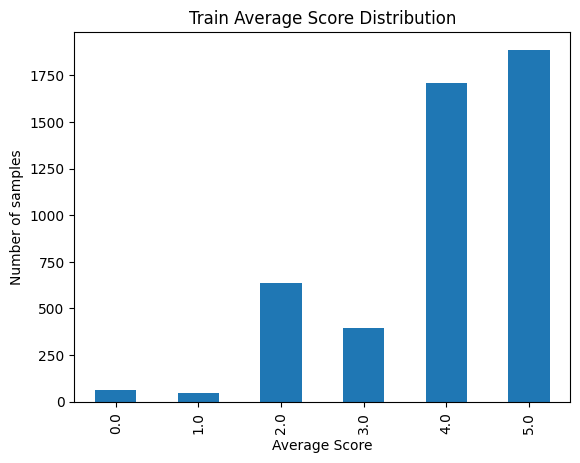

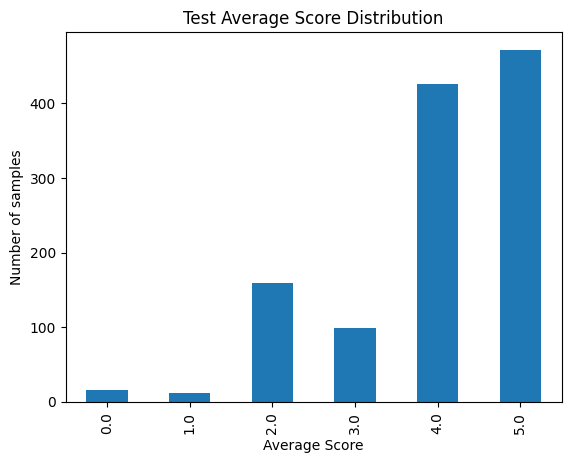

In [ ]:
score_df['combined_embedding'] = score_df.apply(lambda row: np.concatenate((row['question_embedding'], row['refanswer_embedding'], row['answer_embedding']), axis=0), axis=1)

# do train test split with stratification
train_df, test_df = train_test_split(score_df, test_size=0.2, stratify=score_df['score_avg'], random_state=42)
print("Train samples: ", train_df.shape[0])
print("Test samples: ", test_df.shape[0])

train_df['score_avg'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Average Score')
plt.ylabel('Number of samples')
plt.title('Train Average Score Distribution')
plt.show()

test_df['score_avg'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Average Score')
plt.ylabel('Number of samples')
plt.title('Test Average Score Distribution')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.svm import SVC



# Initialize the classifier
# classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# classifier = xgb.XGBClassifier(
#     n_estimators=100,  # Number of trees
#     max_depth=3,       # Maximum depth of each tree
#     learning_rate=0.1, # Learning rate
# )
classifier = SVC(kernel='linear')

# ohe = OneHotEncoder(handle_unknown='ignore')

# Train the classifier on the combined embeddings
X_train = train_df['combined_embedding'].tolist()
# y_train_sparse = ohe.fit_transform(train_df['score_avg'].values.reshape(-1,1))
# y_train = y_train_sparse.toarray()
y_train = train_df['score_avg'].astype('str')
# y_train = train_df['score_avg'].values
classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
X_test = test_df['combined_embedding'].tolist()
y_test = test_df['score_avg'].astype('str')

y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [ ]:
from sklearn import metrics

In [ ]:
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average="weighted")

print("Precision :", precision)
print("Recall :", recall)
print("F1 :", f1)

Precision : 0.8147074053214316
Recall : 0.8137275607180571
F1 : 0.8085101516404255


In [ ]:
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average="weighted")

print("Precision :", precision)
print("Recall :", recall)
print("F1 :", f1)

Precision : 0.6806553148253767
Recall : 0.6959459459459459
F1 : 0.6815574142817047


## NN Classification

In [ ]:
score_df = pd.read_csv('data.csv', index_col=0)
print("Total number of samples: ", score_df.shape[0])
score_df['score_avg'] = score_df['score_avg'].round().astype(int)
score_df.head()

Total number of samples:  5919


,question,refanswer,answer,score_avg
id,,,,
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3


In [ ]:
num_classes = score_df['score_avg'].nunique()
score_df['text'] = "Question :\n" + score_df['question'] + "\nReference Answer:\n" + score_df['refanswer'] + "\nActual Answer:\n" + score_df['answer']

text_samples = score_df['text'].values
labels = score_df['score_avg'].values

In [ ]:
from torch.utils.data import DataLoader, Dataset
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd

train_texts, val_texts, train_labels, val_labels = train_test_split(text_samples, labels, test_size=0.2, random_state=42)


In [ ]:
# prompt: ignore warning

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from transformers import BertTokenizer, BertModel
from torch import nn

class BertClassifier(nn.Module):
  def __init__(self, model_name, num_classes):
    super().__init__()
    self.bert_model = BertModel.from_pretrained(model_name)
    self.dropout = nn.Dropout(0.2)
    self.linear = nn.Linear(self.bert_model.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert_model(input_ids = input_ids, attention_mask = attention_mask)
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    return self.linear(x)

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
  model.train()
  for batch in data_loader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions), f1_score(actual_labels, predictions, average='weighted')

In [ ]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = score_df['score_avg'].nunique()
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

class TextClassificationDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier(bert_model_name, num_classes).to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm import tqdm
for epoch in tqdm(range(num_epochs)):
  # print(f"Epoch {epoch + 1}/{num_epochs}")
  train(model, train_dataloader, optimizer, scheduler, device)
  accuracy, report, f1_score = evaluate(model, val_dataloader, device)
  print(f"\nValidation Accuracy: {accuracy:.4f}")
  print(f"\nF1 Score: {f1_score:.4f}")
  print(report)

In [ ]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return preds.items()